# 02 - Neural Network Classifier & Regressor

#### Uncomment the cell below to pip install the necessary modules if not already installed

#### Note: Works with Qiskit Version 1.4.1 and Quantum Rings Qiskit Toolkit Version 0.1.10

In [1]:
# %pip install matplotlib
# %pip install numpy
# %pip install qiskit==1.4.1
# %pip install qiskit-machine-learning
# %pip install quantumrings-toolkit-qiskit==0.1.10

#### Restart the kernel after installing any of the missing packages

### QNN Classifier & Regressor

This tutorial is the follow up to the notebook on Quantum Neural Networks. If you have not reviewed that notebook it is suggested to view that prior to going through this tutorial. 

In this tutorial we will explore how the `NeuralNetworkClassifier` and `NeuralNetworkRegressor` are used. Both take a Quantum Neural Network (QNN) as input and leverage it in a specific context. A pre-configured variant is provided for convenience, the Variational Quantum Classifier (`VQC`) and Variational Quantum Regressor (`VQR`). The tutorial is split in to two parts as follows:

1. [Classification](#Classification)
   - Classification with an `EstimatorQNN`
   - Classification with a `SamplerQNN`
   - Variational Quantum Classifier (`VQC`)
2. [Regression](#Regression)
   - Regression with an `EstimatorQNN`
   - Variational Quantum Regressor (`VQR`)

Where appropriate, you will see how these methods are implemented using the Quantum Rings Qiskit Toolkit for machine learning. First we will import the necessary modules.


In [2]:
# This code found at:
# https://qiskit-community.github.io/qiskit-machine-learning/tutorials/02_neural_network_classifier_and_regressor.html

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.circuit.library import QNNCircuit

from quantumrings.toolkit.qiskit.machine_learning import QrEstimatorQNN as EstimatorQNN
from quantumrings.toolkit.qiskit.machine_learning import QrSamplerQNN as SamplerQNN

algorithm_globals.random_seed = 42

## Classification

We will prepare a simple classification dataset to illustrate the following algorithms. You may have noticed that we set the `algorithm_globals.random_seed` above to be a constant value. This is done to make the results reproducible and may be changed or removed to make things slightly more random.

We will set up our classifier by defining a number of inputs, samples, X, and Y values. These last two values are used as part of the training and test sets for the classifier. The variable `y_one_hot` is used for the One-hot encoding values which is a standard method of converting categorical data to numerical data and has a specific format that is required for some classifier methods. We will see this used for the Variational Quantum Classifier (`VQC`).

This sets up a binary classification system with 2 features as the inputs and 20 data point samples. We generate 20 points with 2 coordinates uniformly distributed in the range of [-1, 1]. This forms a 20 x 2 matrix of input samples. We follow this by computing the sum of each row ($x_0 + x_1$) and storing this classification in to `y01` such that if the sum is greater than or equal to zero it gets assigned a class `1` otherwise it is class `0`. This creates the basis for our boundary line such that $x_0 + x_1 = 0$ or $x_0 = -x_1$. These labels are then converted from a `{0, 1}` basis to a `{-1, 1}`. We then convert this to a one-hot encoding format for the `VQC` mentioned above. This assigns $0 \rightarrow [1, 0]$ and $1 \rightarrow [0, 1]$.

We will print out a plot to show where the data points start relative to a center line. This center line serves as a decision boundary that separates the different classes based on the relation above of $x_0 = -x_1$ and assigns blue to the class `+1` and green to the class `-1`.

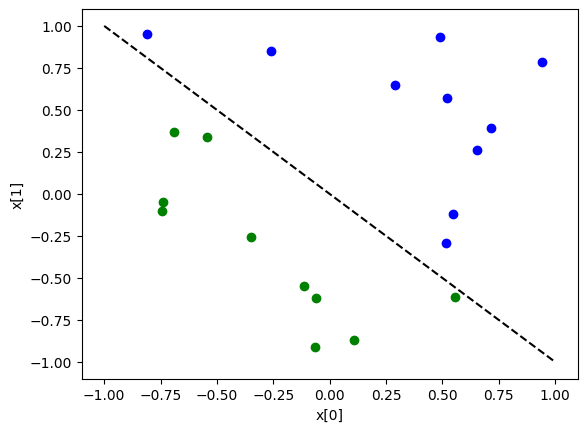

In [4]:
num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.xlabel('x[0]')
plt.ylabel('x[1]')
plt.show()

#### Classification with an `EstimatorQNN`

Now that we've set up our datasets, we will show how an `EstimatorQNN` can be used for classification within a `NeuralNetworkClassifier`. In this context, the `EstimatorQNN` is expected to return one-dimensional output in $[-1, +1]$. This only works for binary classification and we assign the two classes to the set $\{-1, +1\}$. To simplify the composition of parameterized quantum circuit from a feature map and an ansatz we can use the `QNNCircuit` class.

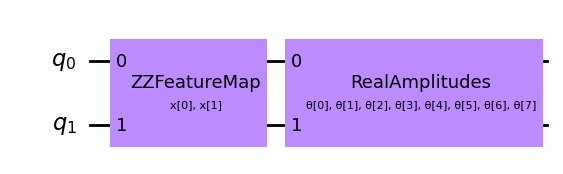

In [5]:
# construct QNN with the QNNCircuit's default ZZFeatureMap feature map and RealAmplitudes ansatz.

qc = QNNCircuit(num_qubits=2)
qc.draw("mpl", style="clifford")

We can use the Quantum Rings Qiskit Toolkit Machine Learning module to create an `EstimatorQNN`. This simplifies the estimator creation process to a single line and only requires us to pass in the quantum circuit we created above. With the qiskit primitives we would have to create a state vector estimator first and pass that in to the `EstimatorQNN`.

In [6]:
# Using Quantum Rings Qiskit Toolkit we create an instance of the EstimatorQNN

estimator_qnn = EstimatorQNN(circuit=qc)

In [7]:
# QNN maps inputs to [-1, +1] using a forward pass of the network

estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))

array([[0.23521988]])

The `callback_graph` function below will be called for each iteration of the optimizer and pass two parameters. It will take the current weights and the value of the objective function at those weights. We will plot the iteration count vs the objective function value and update the graph with each iteration. As long as you give the function the two parameters mentioned, you can do whatever you want with it.

In [8]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [9]:
# construct neural network classifier, we define a COBYLA with max iterations of 60. The callback_graph 
# is passed in for the callback argument which is seen in the plot generation.

estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

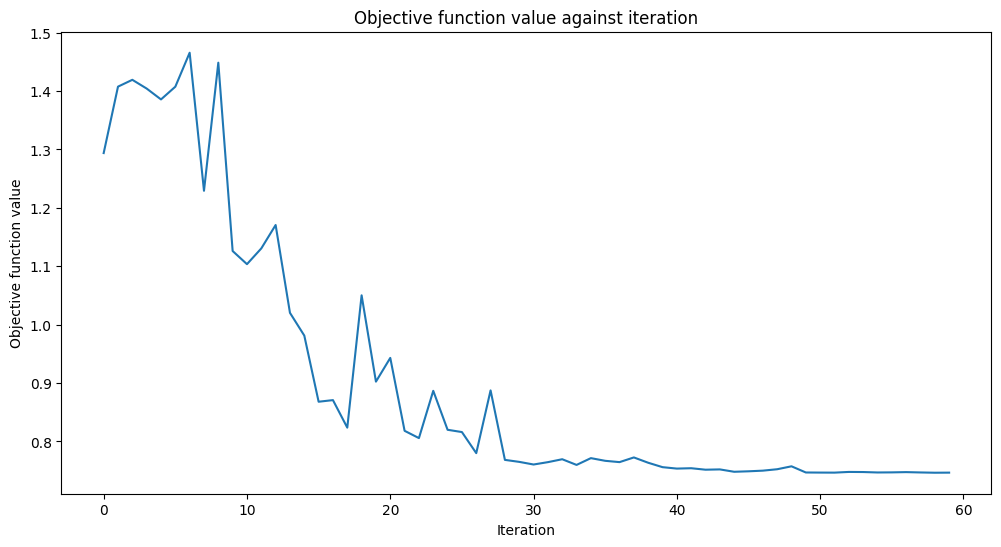

0.8

In [10]:
# create empty array for callback to store evaluations of the objective function

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X, y)

Now we will use the `estimator_classifier` to `predict` the values. This will regenerate the plot above with the data points, this time circling the mis-classified points in red to show that they are wrongly classified. When a point is circled it essentially means that it is on the wrong side of the central line.

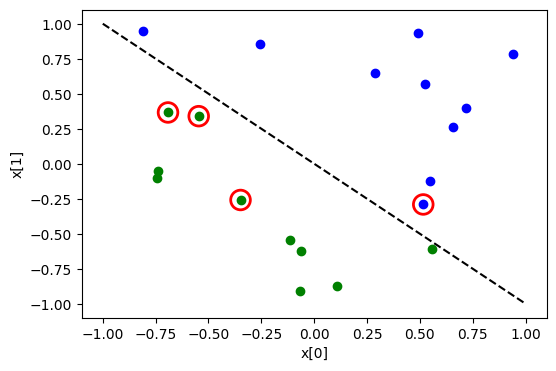

In [11]:
# evaluate data points
y_predict = estimator_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.xlabel('x[0]')
plt.ylabel('x[1]')
plt.show()

We can print out the weights of the classifier neural network. The number of weights is defined by the ansatz.

In [12]:
estimator_classifier.weights

array([ 7.99142399e-01, -1.02869770e+00, -1.32131512e-04, -3.47046684e-01,
        1.13636802e+00,  6.56831727e-01,  2.17902158e+00, -1.08678332e+00])

#### Classification with a `SamplerQNN`

Now we will show how a `SamplerQNN` can be used for classification within a `NeuralNetworkClassifier`. The `SamplerQNN` will return a $d$-dimensional probability vector as output, where $d$ denotes the number of classes (2 in this case). The underlying `Sampler` primitive returns quasi-distributions of bit strings and we just need to define a mapping from the measured bitstrings to the different classes. For binary classification we use the parity mapping. We can use the `QNNCircuit` class to set up a parameterized quantum circuit from a feature map and ansatz of our choice. We will once again use the Quantum Rings Qiskit Toolkit for Machine Learning to create the instance of the `SamplerQNN`. We also pass in our `callback_graph` function from above for generating the iteration vs objective function value plot.

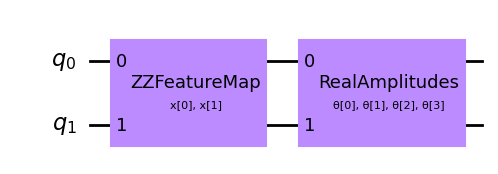

In [13]:
# construct a quantum circuit from the default ZZFeatureMap feature map and a customized RealAmplitudes ansatz
qc = QNNCircuit(ansatz=RealAmplitudes(num_inputs, reps=1))
qc.draw("mpl", style="clifford")

In [14]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [15]:
# construct QNN using the imported sampler from the Quantum Rings Toolkit
# The interpret argument will take in our parity function defined above

sampler_qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
)

In [16]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=30), callback=callback_graph
)

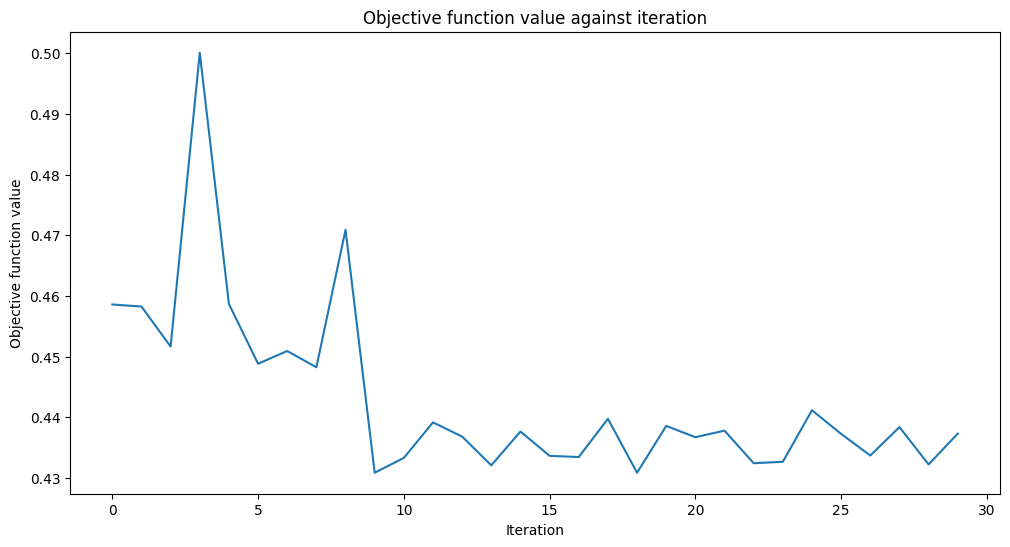

0.55

In [17]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
sampler_classifier.score(X, y01)

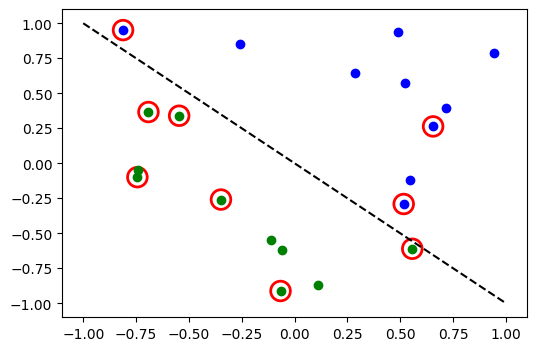

In [18]:
# evaluate data points
y_predict = sampler_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

Since we specify the ansatz reps to `1` we have less weights displayed than before where we were letting the default value fall to the number of qubits. Feel free to play with the number of reps to see how the output changes.

In [19]:
sampler_classifier.weights

array([ 1.75227727,  1.31058654, -0.87633982, -0.32234015])

#### Variational Quantum Classifier (`VQC`)

The `VQC` is a special variant of the `NeuralNetworkClassifier` with a `SamplerQNN`. It applies a parity mapping (or extensions to multiple classes) to map from the bitstring to the classification. This results in a probability vector which is interpreted as a one-hot encoded result. By default, it applies the `CrossEntropyLoss` function that expects labels given in one-hot encoded format and will return predictions in that format too.

In [20]:
# construct feature map, ansatz, and optimizer
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
)

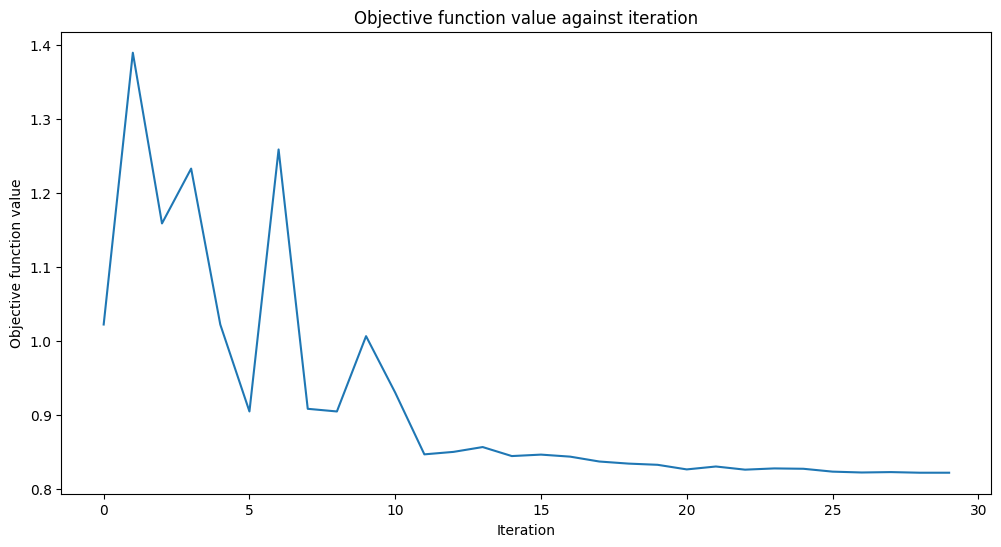

0.8

In [21]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_one_hot)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, y_one_hot)

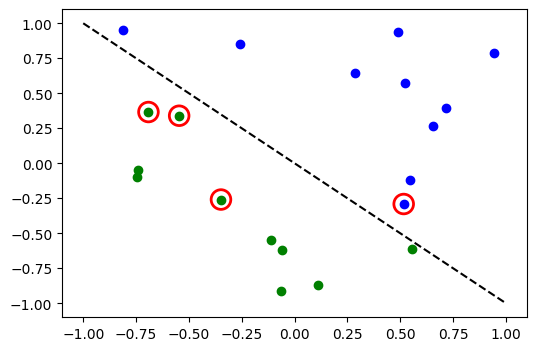

In [22]:
# evaluate data points
y_predict = vqc.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[1] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

#### Multiple classes with `VQC`

Now we will generate an artificial dataset that contains samples of three classes and show how to train a model to classify this dataset. This example shows how to tackle more interesting problems in machine learning, as often times there are multiple classes in a classification problem. For example, consider a situation where you want to classify an image as either a cat or a dog, but what if it is not a cat or a dog? You would need a third class to put as an "Other" category. So typically you will have at least three classes in a classification problem unless you know for a fact that there are only two possible outcomes. 

For the sake of short training time we prepare a tiny dataset. We will employ `make_classification` from SciKit-Learn to generate a dataset. There will be 10 samples and 2 features in the dataset to give us a nice plot of the data with no redundant features. The features are generated as a combination of the other features. We will also have three different classes in the dataset, each classifies one kind of centroid and we will set the class separation to `2.0`, instead of using the default value of `1.0` to make the classification easier. Once the dataset is generated we scale the features into the range `[0, 1]`.

In [23]:
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

X, y = make_classification(
    n_samples=10,
    n_features=2,
    n_classes=3,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.0,
    random_state=algorithm_globals.random_seed,
)
X = MinMaxScaler().fit_transform(X)

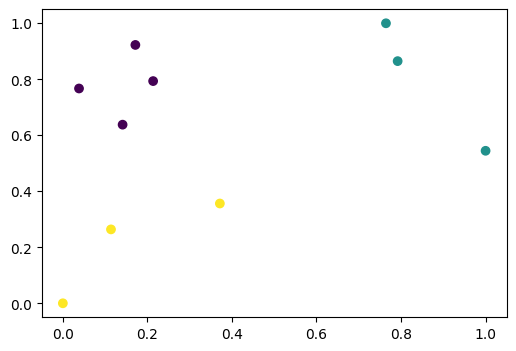

In [24]:
# View the generated data in a scatter plot

plt.scatter(X[:, 0], X[:, 1], c=y)

In [25]:
# Transform the labels and make them categorical

y_cat = np.empty(y.shape, dtype=str)
y_cat[y == 0] = "A"
y_cat[y == 1] = "B"
y_cat[y == 2] = "C"
print(y_cat)

['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


Now we create an instance of `VQC` similar to the previous example. In this case we pass a minimal set of parameters. Instead of a feature map and ansatz we pass just the number of qubits that is equal to the number of features in the dataset, an optimizer with a low number of iterations to reduce training time, and a callback to observe progress.

In [26]:
vqc = VQC(
    num_qubits=2,
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph
)

Start the training process in the same way as the previous example. The `callback_graph` will plot as the iterations complete.

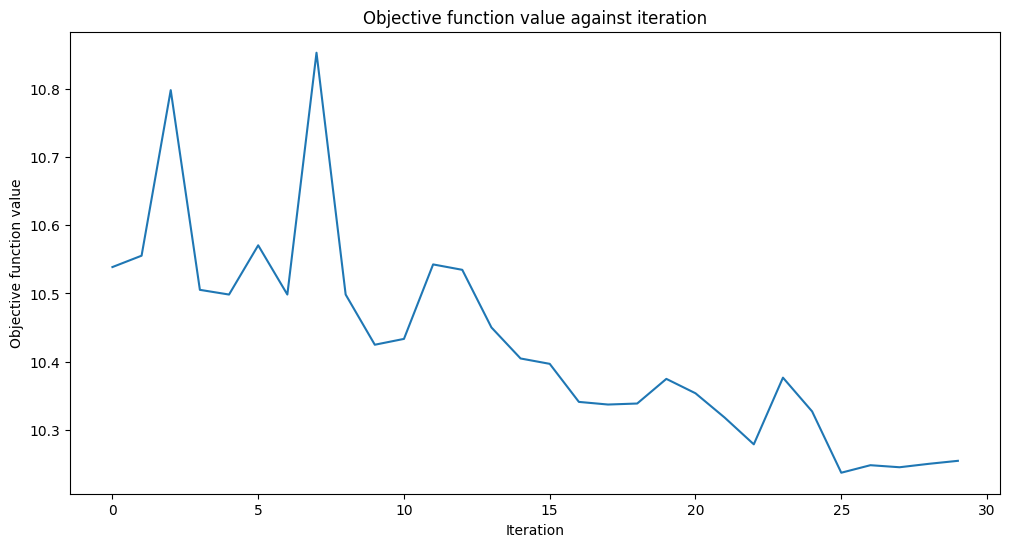

0.7

In [27]:
# create empty array for callback to store evaluations of the objective function

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_cat)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, y_cat)

With a low number of iterations, we would expect a fairly low score. However, this still is able to achieve fairly high accuracy. Feel free to run the above cell multiple times to see if the score improves without increasing the iterations, then increase the iterations to see if you can make it better. Remember, there is a cost trade-off with increased iterations and computation time. 

We can print out the trained model predictions using `predict` and compare them with the ground truth.

In [28]:
predict = vqc.predict(X)
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {y_cat}")

Predicted labels: ['A' 'A' 'B' 'B' 'B' 'A' 'B' 'B' 'A' 'B']
Ground truth:     ['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


The ratio of correct predictions to the ground truth values should be close to the score printed out above. For instance, out of ten values if the score is 0.6 then 6 predictions should be correct and 4 should be incorrect.

### Regression

Now we will explore regression training for QNN. We will go through similar steps as we did with the classification method. The main differences in regression and classification methods lie in the end goal. While classification is attempting to learn what class the data points belong in, regression is attempting to find a pattern that fits an equation that can be used to describe the data. With this equation, it is able to then predict future values based on a given input value. It is essentially trying to find a best-fit line or curve for the provided data set. There are multiple types of regression such as linear, nonlinear, polynomial, logistic, etc. Here we will look at an example of nonlinear regression.

We will start by generating our data as before. We will purposely generate data with values between $-\pi$ and $\pi$ and then plot our data.

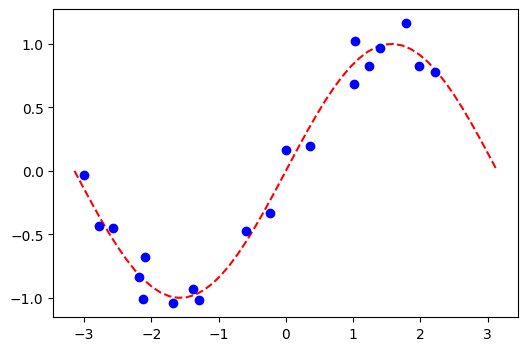

In [29]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
X_ = np.linspace(lb, ub, num=50).reshape(50, 1)
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X[:, 0]) + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

plt.plot(X_, f(X_), "r--")
plt.plot(X, y, "bo")
plt.show()

#### Regression with an `EstimatorQNN`

We will restrict our regression with an `EstimatorQNN` that returns values $[-1, +1]$. More complex and also multi-dimensional models could be constructed, also based on `SamplerQNN`. Feel free to add some cells and try the same process with the `SamplerQNN`.

In [30]:
# construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# construct a circuit
qc = QNNCircuit(feature_map=feature_map, ansatz=ansatz)

# construct QNN using Quantum Rings Qiskit Toolkit
regression_estimator_qnn = EstimatorQNN(circuit=qc)

In [31]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_estimator_qnn,
    loss="squared_error",
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_graph,
)

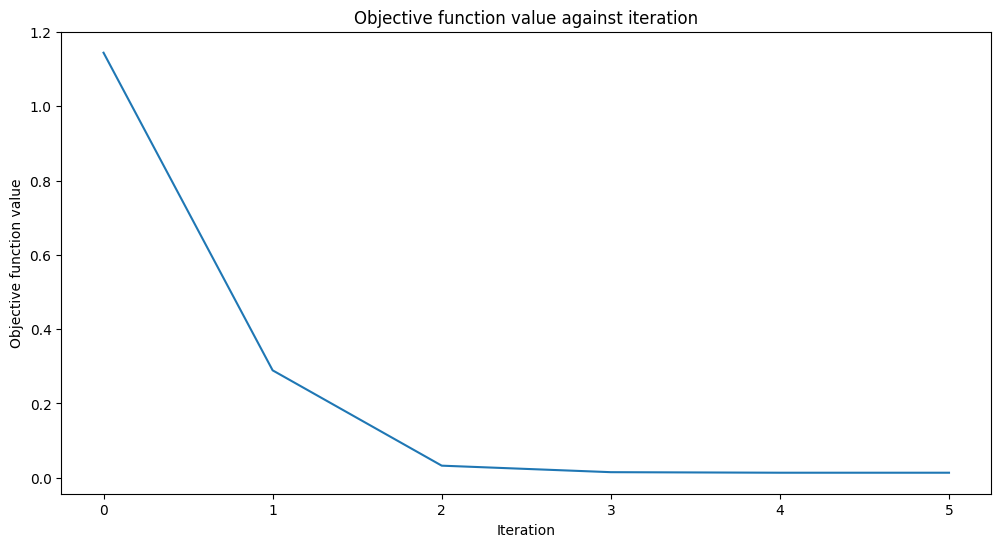

0.9769994291935521

In [32]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score the result
regressor.score(X, y)

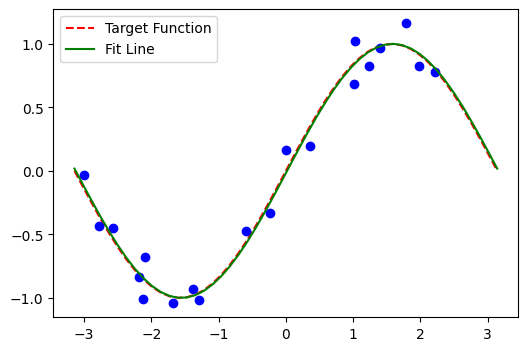

In [33]:
# plot target function
plt.plot(X_, f(X_), "r--", label='Target Function')

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = regressor.predict(X_)
plt.plot(X_, y_, "g-", label='Fit Line')
plt.legend()
plt.show()

Note the high score that is achieved even though we only use 5 iterations. Our fit line from the regression model has near perfect overlap with our target function. Granted this is for a small dataset so feel free to increase the size of the dataset and see how this score changes.

We can print out the regression model weights as before. There is only one parameter defined as `param_y` above so we only have one weight.

In [34]:
regressor.weights

array([-1.58870599])

#### Regression with the Variational Quantum Regressor (`VQR`)

Similar to the `VQC` for classification, the `VQR` is a special variant of the `NeuralNetworkRegressor` with an `EstimatorQNN`. If no `Estimator` is passed then it will create a reference automatically. By default, it considers the `L2Loss` function to minimize the mean squared error between predictions and targets.

In [35]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(maxiter=5),
    callback=callback_graph,
)

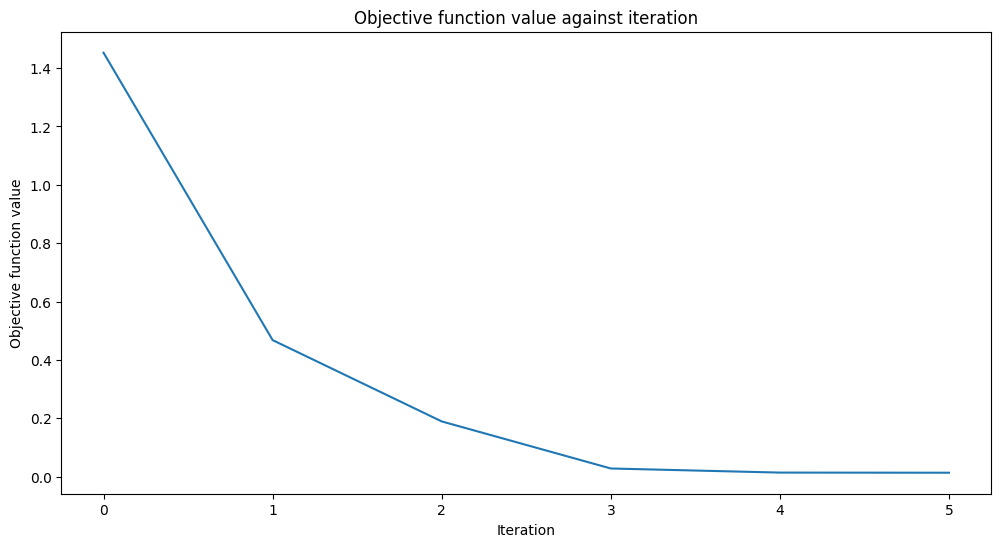

0.9769955693935384

In [36]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score result
vqr.score(X, y)

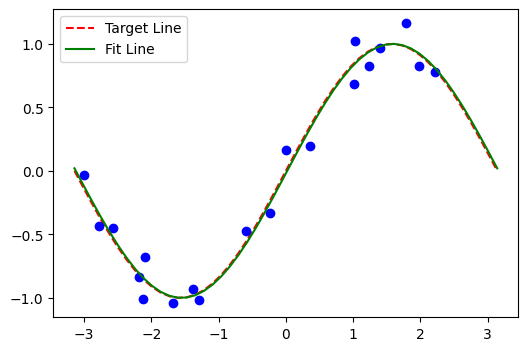

In [37]:
# plot target function
plt.plot(X_, f(X_), "r--", label='Target Line')

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_ = vqr.predict(X_)
plt.plot(X_, y_, "g-", label='Fit Line')
plt.legend()
plt.show()

### Conclusion

Congratulations! You have explored how classification and regression techniques for a QNN using multiple approaches. In the final result, note again the high score with low iterations and how well the line fits. Feel free to play with this data set and iteration counts to see how it changes. There is a lot more to explore in this notebook with just some simple data and/or parameter changes. Machine Learning is a vast subject that has powerful implications. With a QNN and quantum computing these algorithms can be drastically enhanced to achieve higher accuracy in shorter times. 